# Ch.04 機械学習モデル開発の重要ポイント

## 4.4 評価

In [88]:
# 共通事前処理

# データフレーム表示用関数
from IPython.display import display
# ライブラリーのインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings("ignore")

# 表示オプション
# NumPyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasの浮動小数点の表示精度
pd.options.display.float_format = "{:.4f}".format
# データフレームのすべての項目を表示
pd.set_option("display.max_columns", None)
# グラフのスタイルの設定
plt.style.use('seaborn')
# グラフのデフォルトフォント設定
plt.rcParams["font.size"] = 14
# グラフで日本語表示が可能なフォントの設定
plt.rcParams["font.family"] = 'IPAexGothic'
# 乱数の種
RANDOM_SEED = 123

### 4.4.1 混同行列（Confusion Matrix）

- 予測正否（True or False） + 予測結果（positive or negative）
- TP (True Positive)
  - モデルの予測結果が陽性（positive）で、正解（True）だった件数
- FP (False Positive)
  - モデルの予測結果が陽性（positive）で、不正解（False）だった件数
- FN (False Negative)
  - モデルの予測結果が陰性（negative）で、不正解（False）だった件数
- TN (True Negative)
  - モデルの予測結果が陰性（negative）で、正解（True）だった件数

混合行列の実装

In [89]:
# データ読み込みからデータ分割まで

# ライブラリのインポート
from sklearn.datasets import load_breast_cancer

# データのロード
cancer = load_breast_cancer()

# 入力データ x
x = cancer.data

# 正解データ y
# 「良性: 0」、「悪性: 1」に値を変更する
# 「悪性」=「陽性」= 1
y = 1 - cancer.target

# 入力データを2次元に絞り込む
x2 = x[:, :2]

# データ分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x2, y, train_size=0.7, test_size=0.3, random_state=RANDOM_SEED
)

In [90]:
# アルゴリズム選択から評価まで

# アルゴリズム選択（ロジスティック回帰）
from sklearn.linear_model import LogisticRegression

algorithm = LogisticRegression(random_state=RANDOM_SEED)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 評価
score = algorithm.score(x_test, y_test)

# 結果確認
print(f"score: {score:.4f}")

score: 0.8772


In [91]:
# 混合行列の計算

# ライブラリのインポート
from sklearn.metrics import confusion_matrix

# 混合行列の生成
# y_test: 検証データの正解データ
# y_pred: 検証データの予測結果
matrix =confusion_matrix(y_test, y_pred)

# 結果確認
print(matrix)

[[101   2]
 [ 19  49]]


In [92]:
# 混合行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy 配列

    # columns項目名のリスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    # データフレーム生成
    cm =pd.DataFrame(
        matrix, columns=[pred, columns], index=[act, columns]
    )
    return cm

In [93]:
# make_cmを使った混合行列の表示
cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
           良性  悪性
正解データ 良性  101   2
      悪性   19  49

### 4.4.2 精度・適合率・再現率・F値

- 精度（Accuracy）
  - 正解数を全体件数で割った比
  - $(正解数) / (全体件数) = TP + TN / TP + FP + FN + TN$
- 適合率（Precision）
  - モデルが「陽性」と予測した対象のうち、本当に「陽性」だった割合
  - TP / TP + FP
- 再現率（Recall）
  - 本当に「陽性」だったデータのうち、どの程度をモデルで「陽性」と検知できたか
  - TP / TP + FN
- F 値（F-score）
  - 2 * (適合率) * (再現率) / (適合率) + (再現率)

In [94]:
# 適合率・再現率・F値の計算

# ライブラリのインポート
from sklearn.metrics import precision_recall_fscore_support

# 適合率・再現率・F値の計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)

# 結果の確認
print(f"適合率: {precision:.4f}")
print(f"再現率: {recall:.4f}")
print(f"F値: {fscore:.4f}")
display(cm)

適合率: 0.9608
再現率: 0.7206
F値: 0.8235


予測結果    
           良性  悪性
正解データ 良性  101   2
      悪性   19  49

### 4.4.3 確率値としきい値

In [95]:
# 確率値の取得
# 入力変数のデータ件数: N件
# N行2列のNumPy配列
# 1列目: 予測結果「y=0」に対する確率値
# 2列目: 予測結果「y=1」に対する確率値
y_proba = algorithm.predict_proba(x_test)
print(y_proba[10:20, :])

[[0.7889 0.2111]
 [0.0812 0.9188]
 [0.8383 0.1617]
 [0.9391 0.0609]
 [0.369  0.631 ]
 [0.9451 0.0549]
 [0.9399 0.0601]
 [0.9494 0.0506]
 [0.9617 0.0383]
 [0.9836 0.0164]]


In [96]:
# positive(1)の確率値の取得
y_proba1 = y_proba[:, 1]

# 結果確認
print(y_test[10:20])
print(y_pred[10:20])
print(y_proba1[10:20])

[0 1 1 0 1 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [97]:
# しきい値を変化させる
thres = 0.5
print((y_proba1[10:20] > thres).astype(int))

thres = 0.7
print((y_proba1[10:20] > thres).astype(int))

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [98]:
# しきい値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得（行列）
    y_proba = algorithm.predict_proba(x)

    # 予測結果1の確率値
    y_proba1 = y_proba[:, 1]

    # 予測結果1の確率値 > しきい値
    y_pred = (y_proba1 > thres).astype(int)

    return y_pred

In [99]:
# しきい値0.5で予測結果取得
pred_05 = pred(algorithm, x_test, 0.5)

# しきい値0.7で予測結果取得
pred_07 = pred(algorithm, x_test, 0.7)

# 結果の確認
print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


### 4.4.4 PR曲線とROC曲線

PR曲線（Precision-Recall Curve）

In [100]:
# PR曲線用の配列の生成

# ライブラリのインポート
from sklearn.metrics import precision_recall_curve

# 適合率・再現率・しきい値の取得
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba1
)

# 結果をデータフレームにする
df_pr = pd.DataFrame([thresholds, precision, recall]).T
df_pr.columns = ['しきい値', '適合率', '再現率']

# しきい値0.5の周辺の表示
# display(df_pr[52:122:10])
display(df_pr[50:171:10])

,しきい値,適合率,再現率
50,0.0308,0.5455,0.9706
60,0.0464,0.5856,0.9559
70,0.0579,0.6337,0.9412
80,0.0870,0.7033,0.9412
90,0.1473,0.7901,0.9412
100,0.2027,0.8310,0.8676
110,0.3371,0.9344,0.8382
120,0.5347,0.9608,0.7206
130,0.7763,0.9756,0.5882
140,0.9025,1.0000,0.4559


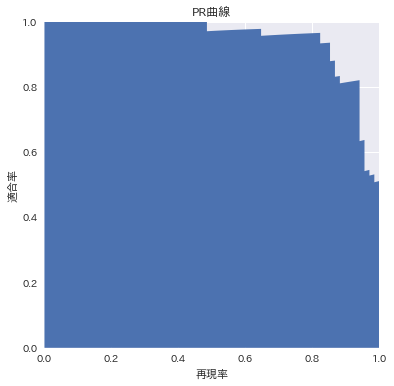

In [101]:
# PR曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6, 6))

# グラフ領域の塗りつぶし
plt.fill_between(recall, precision, 0)

# x, yの範囲指定
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

# ラベル・タイトル表示
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')

plt.show()

In [102]:
# PR曲線下面積の計算
# auc (area under the curve)
from sklearn.metrics import auc

pr_auc = auc(recall, precision)
print(f"PR曲線下面積: {pr_auc:.4f}")

PR曲線下面積: 0.9459


ROC曲線（Receiver Operating Characteristic）

- 敏感度
  - 青: 正解データが陽性
  - しきい値より右の面積 / 青全体の面積
  - TP / TP + FN
- 偽陽性率
  - 黒: 正解データが陰性
  - しきい値より右の面積 / 黒全体の面積
  - FP / FP + TN

In [103]:
# ROC曲線用の配列の生成

# ライブラリのインポート
from sklearn.metrics import roc_curve

# 偽陽性率・敏感度・しきい値の取得
fpr, tpr, thresholds = roc_curve(
    y_test, y_proba1, drop_intermediate=False
)

# 結果をデータフレームにする
df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['しきい値', '偽陽性', '敏感度']

# しきい値0.5の周辺を表示
display(df_roc[21:91:10])

,しきい値,偽陽性,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412


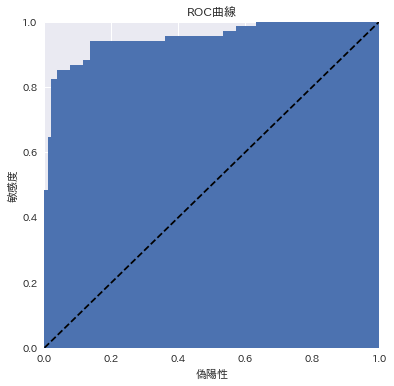

In [104]:
# ROC曲線の描画

# 棒がサイズの設定
plt.figure(figsize=(6, 6))

# 点線表示
plt.plot([0, 1], [0, 1], 'k--')

# グラフ領域の塗りつぶし
plt.fill_between(fpr, tpr, 0)

# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# ラベル・タイトル表示
plt.xlabel('偽陽性')
plt.ylabel('敏感度')
plt.title('ROC曲線')

plt.show()

In [105]:
# ROC曲線下面積の計算
roc_auc = auc(fpr, tpr)
print(f"ROC曲線下面積: {roc_auc:.4f}")

ROC曲線下面積: 0.9522


|ROC曲線下面積|性能|
|:-:|:-:|
|0.9-1.0|高性能|
|0.7-9.0|中性能|
|0.5-0.7|低性能|

より精度のいいモデルでROCカーブを描画

In [106]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, test_size=0.3, random_state=RANDOM_SEED
)

algorithm = LogisticRegression()
algorithm.fit(x_train, y_train)

y_pred = algorithm.predict(x_test)
y_proba1 = algorithm.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba1)

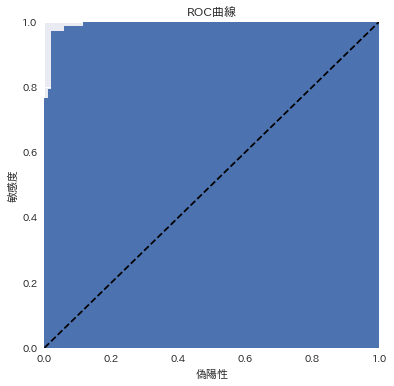

In [107]:
# ROC曲線の描画

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.fill_between(fpr, tpr, 0)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('偽陽性')
plt.ylabel('敏感度')
plt.title('ROC曲線')

plt.show()

In [108]:
# ROC AUCの計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

ROC曲線下面積:0.9937


### 4.4.5 入力項目の重要度

In [109]:
# ランダムフォレストのモデルを作るまで

# サンプルデータの読み込み
import seaborn as sns
df_iris = sns.load_dataset("iris")
columns_i = ['がく片長', 'がく片幅', '花弁長', '花弁幅', '種別']
df_iris.columns = columns_i

# 入力データ x
x = df_iris[['がく片長', 'がく片幅', '花弁長', '花弁幅']]

# 正解データ y
y = df_iris['種別']

# アルゴリズムの選択（ランダムフォレスト）
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=RANDOM_SEED)

# 学習
algorithm.fit(x, y)

# パラメータ表示
print(algorithm.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


重要度ベクトルの取得

In [110]:
# 重要度ベクトルの取得
importances = algorithm.feature_importances_

# 項目名をキーにSeriesを生成
w = pd.Series(importances, index=x.columns)

# 値の大きい順にソートする
u = w.sort_values(ascending=False)

# 結果確認
print(u)

花弁長    0.4611
花弁幅    0.4257
がく片長   0.0874
がく片幅   0.0257
dtype: float64


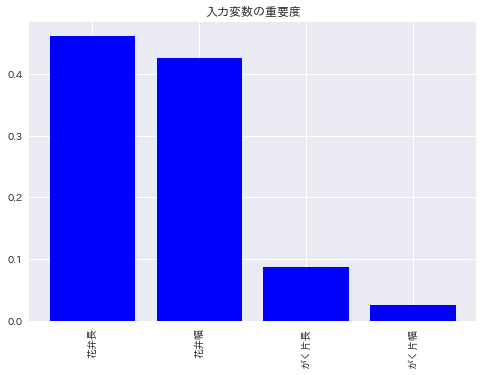

In [111]:
# 重要度の棒グラフ表示

# 棒グラフ表示
plt.bar(range(len(u)), u, color='b', align='center')

# 項目名表示（90度回転）
plt.xticks(range(len(u)), u.index, rotation=90)

# タイトル表示
plt.title('入力変数の重要度')

plt.show()

花弁長    0.5507
花弁幅    0.4226
がく片長   0.0267
がく片幅   0.0000
dtype: float64


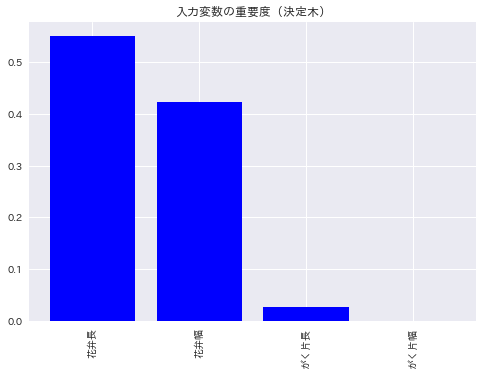

In [112]:
# 決定木の場合

from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=RANDOM_SEED)

algorithm.fit(x, y)

importances = algorithm.feature_importances_

w = pd.Series(importances, index=x.columns)

u = w.sort_values(ascending=False)
print(u)

plt.title('入力変数の重要度（決定木）')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

In [117]:
# XGBoostの場合

import xgboost
algorithm = xgboost.XGBClassifier(random_state=RANDOM_SEED)

algorithm.fit(x, y)

importances = algorithm.feature_importances_

w = pd.Series(importances, index=x.index)

u = w.sort_values(ascending=False)
print(u)

plt.title('入力変数の重要度（XGBoost）')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['setosa' 'versicolor' 'virginica']

花弁長    0.6766
花弁幅    0.2974
がく片幅   0.0165
がく片長   0.0096
dtype: float32


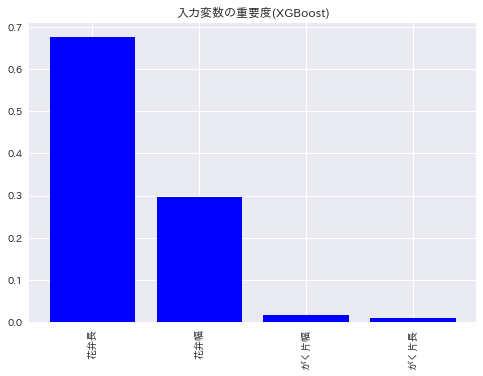

In [127]:
import xgboost
algorithm = xgboost.XGBClassifier(random_state=RANDOM_SEED)

y_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
y1 = y.copy()
y1 = y1.map(y_map)

algorithm.fit(x, y1)
importances = algorithm.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
print(u)

plt.title('入力変数の重要度(XGBoost)')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()


### 4.4.6 回帰モデルの評価方法

In [130]:
# データ読み込みからデータ分割まで

# データの読み込み（ボストン・データセット）
from sklearn.datasets import load_boston
boston = load_boston()

# df: 入力データ 
df = pd.DataFrame(boston.data, columns=boston.feature_names)

# y: 正解データ
y = boston.target

# 1項目だけの入力データdf1を作る
df1 = df[['RM']]

# 結果確認
display(df.head())
display(df1.head())
print(y[:5])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0063,18.0000,2.3100,0.0000,0.5380,6.5750,65.2000,4.0900,1.0000,296.0000,15.3000,396.9000,4.9800
1,0.0273,0.0000,7.0700,0.0000,0.4690,6.4210,78.9000,4.9671,2.0000,242.0000,17.8000,396.9000,9.1400
2,0.0273,0.0000,7.0700,0.0000,0.4690,7.1850,61.1000,4.9671,2.0000,242.0000,17.8000,392.8300,4.0300
3,0.0324,0.0000,2.1800,0.0000,0.4580,6.9980,45.8000,6.0622,3.0000,222.0000,18.7000,394.6300,2.9400
4,0.0691,0.0000,2.1800,0.0000,0.4580,7.1470,54.2000,6.0622,3.0000,222.0000,18.7000,396.9000,5.3300


,RM
0,6.5750
1,6.4210
2,7.1850
3,6.9980
4,7.1470


[24.  21.6 34.7 33.4 36.2]


In [131]:
# アルゴリズム選定から予測まで

# アルゴリズム: XGBRegressor
from xgboost import XGBRegressor
algorithm1 = XGBRegressor(
    objective='reg:squarederror', random_state=RANDOM_SEED
)

# 学習（入力データにdf1を利用）
algorithm1.fit(df1, y)

# 予測
y_pred1 = algorithm1.predict(df1)

# アルゴリズム: XGBRegressor
algorithm2 = XGBRegressor(
    objective='reg:squarederror', random_state=RANDOM_SEED
)

# 学習 (入力データにdfを利用)
algorithm2.fit(df, y)

# 予測
y_pred2 = algorithm2.predict(df)

In [132]:
# 結果確認
print(f"y[:5]: {y[:5]}")
print(f"y_pred1[:5]: {y_pred1[:5]}")
print(f"y_pred2[:5]: {y_pred2[:5]}")

y[:5]: [24.  21.6 34.7 33.4 36.2]
y_pred1[:5]: [24.2265 20.5349 34.8044 32.9725 35.9762]
y_pred2[:5]: [24.0193 21.5997 34.7074 33.4074 36.1893]


In [133]:
# yの最大値と最小値の計算
y_range = np.array([y.min(), y.max()])

# 結果確認
print(y_range)

[ 5. 50.]


散布図表示

1入力変数の場合 

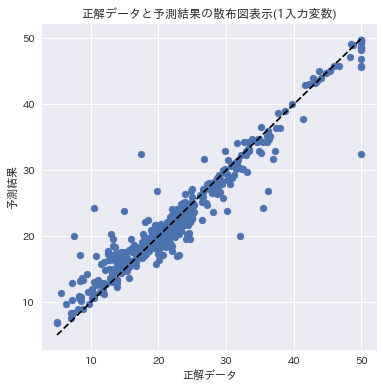

In [134]:
# 散布図による結果確認（入力変数 1）

# 描画サイズ指定
plt.figure(figsize=(6, 6))

# 散布図表示
plt.scatter(y, y_pred1)

# 正解データ = 予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(1入力変数)')

plt.show()

13入力変数の場合

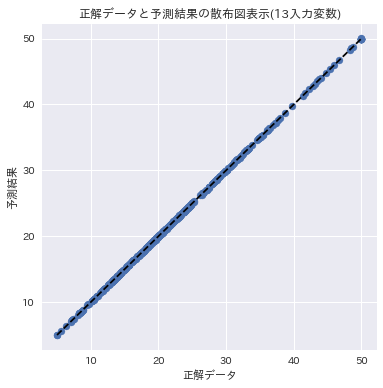

In [135]:
# 散布図による結果確認(入力変数 13)

# 描画サイズ指定
plt.figure(figsize=(6, 6))

# 散布図
plt.scatter(y, y_pred2)

# 正解データ=予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(13入力変数)')

plt.show()

決定係数（R2 score）

In [136]:
# r2 scoreの計算(1入力変数

from sklearn.metrics import r2_score

r2_score1 = r2_score(y, y_pred1)
print(f'R2 score(1入力変数): {r2_score1:.4f}')

R2 score(1入力変数): 0.9251


In [137]:
# r2 scoreの計算(13入力変数)

r2_score2 = r2_score(y, y_pred2)
print(f'R2 score(13入力変数): {r2_score2:.4f}')

R2 score(13入力変数): 1.0000


- MAPE（平均絶対誤差率）
- RMSE（Root Mean Square Error）
- MAE（Mean Absolute Error）